In [1]:
import torch
import torch.nn as nn
import utils
import time

from vgg import Vgg16
from coco_dataset import CocoDataset
from transfer_net import TransferNet
from PIL import Image
from torchvision import transforms

In [2]:
## params
epochs = 1
batch_size = 4
learning_rate = 1e-3
content_weight = 1e5
style_weight = 1e10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
coco = CocoDataset('../data/coco_data')
train_loader = torch.utils.data.DataLoader(coco, batch_size=batch_size, shuffle=True)

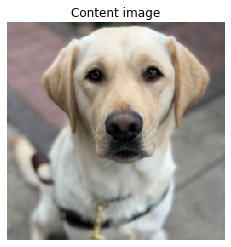

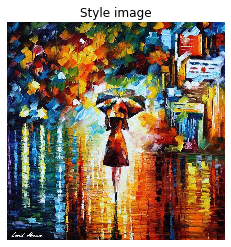

In [4]:
## Get content and style image
content_image = Image.open('../data/test_data/dog.jpg')
content_image = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])(content_image).unsqueeze(0)
utils.display_image(content_image.squeeze(), 'Content image')
style_image = Image.open('../data/styles/rain_princess.jpg')
utils.display_image(transforms.ToTensor()(style_image), 'Style image')

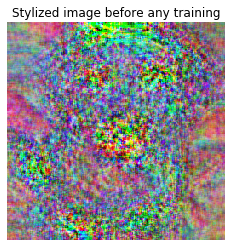

In [5]:
## Create the transfer network and check that it works well
transfer_net = TransferNet().eval()
output = transfer_net(content_image)
utils.display_image(output.detach().squeeze(), 'Stylized image before any training')

In [6]:
## Create Vgg16 and feed forward the style to extract the style features
vgg = Vgg16().to(device)

## Transform the style image to a full batch on the selected device
vgg_transform_pipeline = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
style_image_batch = vgg_transform_pipeline(style_image)
style_image_batch = style_image_batch.repeat(batch_size, 1, 1, 1).to(device)

## Normalize for vgg input
features_style = vgg(utils.normalize_batch(style_image_batch))

## Compute the style gram matrix: y_s
gram_style = [utils.gram_matrix(y) for _, y in features_style.items()]

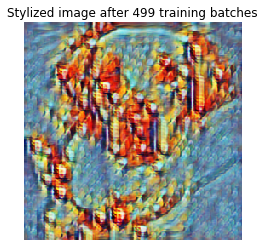

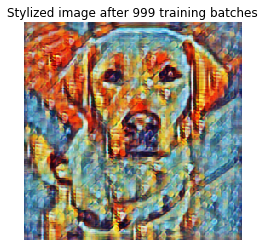

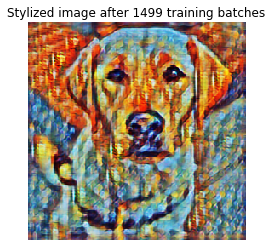

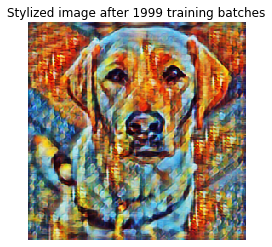

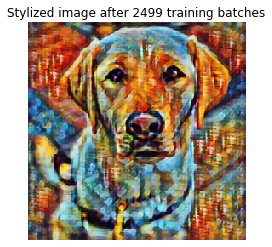

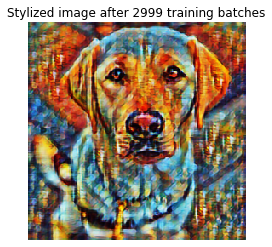

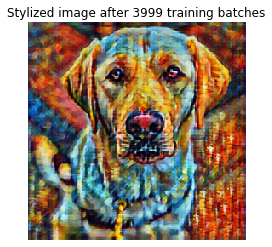

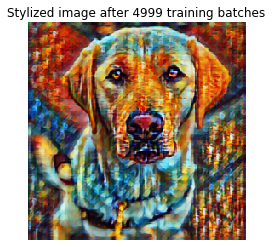

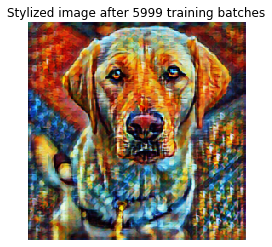

In [7]:
## Training
start = time.time()
## Put transfer net on selected device in training mode
transfer_net.to(device).train()
optimizer = torch.optim.Adam(transfer_net.parameters(), learning_rate)
mse_loss = nn.MSELoss()
for epoch in range(epochs):
    for i, x in enumerate(train_loader):
        optimizer.zero_grad()
        
        ## Put batch on selected device and feed it through the transfer
        ## network without normalization
        x = x.to(device)    ## x = y_c = content target
        y = transfer_net(x) ## y_hat
        
        ## Normalize batch and transfer net output for vgg
        x = utils.normalize_batch(x)
        y = utils.normalize_batch(y)
        
        ## Extract features with vgg
        features_y = vgg(y)
        features_x = vgg(x)
        
        ## Compute Perceptual Loss Functions
        ## Content loss: Feature Reconstruction Loss in the paper, is just a simple MSE loss between y_hat and y_c relu3_3
        content_loss = content_weight * mse_loss(features_y['relu3_3'], features_x['relu3_3'])
        
        ## Style loss: Style Reconstruction Loss: MSE between the gram matrices of y_hat and y_s
        style_loss = 0.
        for ft_y, gm_s in zip(features_y.values(), gram_style):
            gm_y = utils.gram_matrix(ft_y)
            style_loss += mse_loss(gm_y, gm_s)
        style_loss *= style_weight
        
        ## todo: Compute Simple Loss Functions
        
        ## Backward and optimization
        total_loss = content_loss + style_loss
        total_loss.backward()
        optimizer.step()
        
        if i == 499 or i == 999 or i == 1499 or i == 1999 or i == 2499 or i == 2999 or i == 3999 or i == 4999 or i == 5999:
            transfer_net.cpu().eval()
            output = transfer_net(content_image)
            utils.display_image(output.detach().squeeze(), 'Stylized image after ' + str(i) + ' training batches')
            transfer_net.to(device).train()
            if i == 5999:
                break
runtime = time.time() - start

In [8]:
print('Total runtime: {:.2f}min'.format(runtime / 60.))

Total runtime: 51.74min
